# Codigo del tp Realizado con Python

Creamos una clase instancia para poder guardar todo lo relativo con cada una de las instancias (archivos) de entrada, esta genera la matriz CMM , el vector b para la ecuacion Cb=r, para resolver esto es necesario crear una instancia de la clase usar
`ins = Instancia(PATH_ARCHIVO,BOOL)` 
donde el primer parametro del contructor es el path del archivo y el segundo un bool que si es true le presta atencion a los empates, si no los ignora(el default es false y no hace falta enviarlo.
por ej:
`ins = Instancia("tests/tests_nuestros/testEmpate.in",True)` o `ins = Instancia("tests/test1.in")` . 


In [264]:
import numpy as np
import pandas as pd
import math
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
class Instancia():
    def __init__(self,csvfile,contarEmpates=False,empateSuma=True):
        self._equipos=0
        self._partidos=0
        self._cmm = None
        self.mass=None
        self.diferencia=None
        self.ganados = None
        self.enfrentamientos = None
        self.ganadosEmpates = None
        self.totales = None
        self.ratings=None
        f = open(csvfile, "r")
        i=0
        for line in list(f):
            if i == 0: # header
                i+=1
                columns = line.split()
                self._equipos = int(columns[0])
                self._partidos = int(columns[1])
                self._cmm = np.empty([self._equipos,self._equipos])
                self.ganados= np.empty([self._equipos,self._equipos])
                self.enfrentamientos= np.empty([self._equipos,self._equipos])
                self.totales = np.zeros(self._equipos)
#                 self.diferencias = np.zeros(self._equipos)
                self.ratings = np.ones(self._equipos)*100
                for i in range(0,self._equipos):
                    for j in range(0,self._equipos):
                        self.ganados[i,j]=0.0
                        self.ganados[j,i]=0.0
                        self.enfrentamientos[i,j]=0.
                        self.enfrentamientos[j,i]=0.
            else:
                data = line.split();
                print(data)

                equipo1=int(data[1])-1
                goles1=int(data[2])-1
                equipo2=int(data[3])-1
                goles2=int(data[4])-1
#                 solo aplica para colley
                if((contarEmpates and goles1==goles2) or goles1-goles2!=0):
                    self.totales[int(data[1])-1]+=1
                    self.totales[int(data[3])-1]+=1
                    

#                 self.diferencias[int(data[1])-1]+=int(data[2])
#                 self.diferencias[int(data[1])-1]-=int(data[4])
#                 self.diferencias[int(data[3])-1]+=int(data[4])
#                 self.diferencias[int(data[3])-1]-=int(data[2])
                
                r1= self.getEloRating(equipo1,equipo2,goles1,goles2,True)
                r2 =self.getEloRating(equipo2,equipo1,goles2,goles1)
                
                self.ratings[equipo1]=r1
                self.ratings[equipo2]=r2
                if contarEmpates and goles1==goles2:
                    self.enfrentamientos[equipo1,equipo2]+=1
                    self.enfrentamientos[equipo2,equipo1]+=1
                elif goles1-goles2!=0:
                    self.enfrentamientos[equipo1,equipo2]+=1
                    self.enfrentamientos[equipo2,equipo1]+=1
                    
                if goles1>goles2:
                    print('gana '+str(data[1]))
                    self.ganados[equipo1,equipo2] +=1
                elif goles2>goles1:
                    print('gana '+str(data[3]))
                    self.ganados[equipo2,equipo1] +=1
                elif goles1==goles2 and contarEmpates:
                    print('empate' + str(data[1])+'-'+str(data[3]))
                    if(empateSuma):
                        self.ganados[equipo2,equipo1] +=1
                        self.ganados[equipo1,equipo2] +=1
                        
                    
#             construyo la matriz de cmm
        for i in range(0, ins.equipos()):
            for j in range(0, ins.equipos()):
                if i==j:
                    self._cmm[i][j]=  self.totales[i]+ 2
                else:
                    self._cmm[i][j]=  self.enfrentamientos[i,j]*-1         
#         Construyo el vector b                  
        self.b = np.zeros(self.equipos())
        for i in range(0,self.equipos()):
            ganados =0
            for j in range(0,self.equipos()):
                ganados += self.ganados[i][j]
            self.b[i]= 1+(2*ganados-self.totales[i])/2
                          
    def getEloRating(self,equipo1,equipo2,goles1,goles2,esLocal=False,K=60):
        r0_1 = self.ratings[equipo1]
        r0_2 = self.ratings[equipo2]
        
        df1 = int(goles1-goles2)
        G =0
        if df1==0 or df1==1:
            G=1
        elif df1 == 2:
            G = 1.5
        else:
            G=(11+ abs(df1))/8
#         // W is the result of the game (1 for a win, 0.5 for a draw, and 0 for a loss).
        W=0
        if df1==0:
            W=0.5;
        elif df1>0:
            W=1;

        dr=.0;
        if esLocal :
            dr = (r0_1-r0_2+100)*-1;
        else:
            dr = (r0_1-r0_2)*-1;

        W_e = 1 / (pow(10,(dr/400)) + 1);
        return r0_1+ G*(W-W_e);

    def equipos(self):
        return self._equipos
    def partidos(self):
        return self._partidos
    def cmm(self):
        
        return self._cmm
    def wp(self):
        wp = np.zeros(self._equipos)
        for i in range(0,self._equipos):
            wp[i]=sum(self.ganados[i])/self.totales[i]
        
        return wp



def forward_elimination(A, b, n):
    """
    Calculates the forward part of Gaussian elimination.
    """
    for row in range(0, n-1):
        for i in range(row+1, n):
            factor = A[i,row] / A[row,row]
            for j in range(row, n):
                A[i,j] = A[i,j] - factor * A[row,j]

            b[i] = b[i] - factor * b[row]

#         print('A = \n%s and b = %s' % (A,b))
    return A, b

def back_substitution(a, b, n):
    """"
    Does back substitution, returns the Gauss result.
    """
    x = np.zeros((n,1))
    x[n-1] = b[n-1] / a[n-1, n-1]
    for row in range(n-2, -1, -1):
        sums = b[row]
        for j in range(row+1, n):
            sums = sums - a[row,j] * x[j]
        x[row] = sums / a[row,row]
    return x

def gauss(A, b):
    """
    This function performs Gauss elimination without pivoting.
    """
    n = A.shape[0]

    # Check for zero diagonal elements
    if any(np.diag(A)==0):
        raise ZeroDivisionError(('Division by zero will occur; '
                                  'pivoting currently not supported'))
    
    A, b = forward_elimination(A, b, n)
    return back_substitution(A, b, n)

# Contemos Empates

##### Veamos en esta seccion que pasa si contamos empate sumandole como una victoria a cada uno

In [265]:
ins = Instancia("tests/tests_nuestros/testEmpate.in",True)

['1', '1', '1', '4', '1']
empate1-4
['1', '2', '38', '5', '17']
gana 2
['1', '2', '0', '6', '1']
gana 6
['1', '3', '34', '1', '21']
gana 3
['1', '3', '23', '4', '10']
gana 3
['1', '4', '31', '1', '6']
gana 4
['1', '5', '0', '6', '1']
gana 6
['1', '5', '38', '4', '23']
gana 5
['1', '6', '1', '2', '0']
gana 6
['1', '6', '1', '5', '0']
gana 6
['1', '4', '1', '6', '0']
gana 4
['1', '3', '1', '1', '0']
gana 3
['1', '3', '1', '2', '0']
gana 3


### veamos nuestra matriz CMM

In [266]:
ins._cmm

array([[ 6., -0., -2., -2., -0., -0.],
       [-0.,  6., -1., -0., -1., -2.],
       [-2., -1.,  6., -1., -0., -0.],
       [-2., -0., -1.,  7., -1., -1.],
       [-0., -1., -0., -1.,  6., -2.],
       [-0., -2., -0., -1., -2.,  7.]])

### veamos el total de enfrentamientos y partidos ganados entre equipos

In [267]:
ins.enfrentamientos

array([[0., 0., 2., 2., 0., 0.],
       [0., 0., 1., 0., 1., 2.],
       [2., 1., 0., 1., 0., 0.],
       [2., 0., 1., 0., 1., 1.],
       [0., 1., 0., 1., 0., 2.],
       [0., 2., 0., 1., 2., 0.]])

In [268]:
ins.ganados

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [2., 1., 0., 1., 0., 0.],
       [2., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 2., 0., 0., 2., 0.]])

In [269]:
ins.b

array([0. , 0. , 3. , 1.5, 0. , 2.5])

In [270]:
# Resuelvo la ecuacion Cb=r para obtener raitings
res = gauss(ins._cmm,ins.b)

In [271]:
res

array([[0.4912234 ],
       [0.43803191],
       [0.84202128],
       [0.63164894],
       [0.40797872],
       [0.68909574]])

## Misma instancia ignorando empates

In [272]:
ins2 = Instancia("tests/tests_nuestros/testEmpate.in")

['1', '1', '1', '4', '1']
['1', '2', '38', '5', '17']
gana 2
['1', '2', '0', '6', '1']
gana 6
['1', '3', '34', '1', '21']
gana 3
['1', '3', '23', '4', '10']
gana 3
['1', '4', '31', '1', '6']
gana 4
['1', '5', '0', '6', '1']
gana 6
['1', '5', '38', '4', '23']
gana 5
['1', '6', '1', '2', '0']
gana 6
['1', '6', '1', '5', '0']
gana 6
['1', '4', '1', '6', '0']
gana 4
['1', '3', '1', '1', '0']
gana 3
['1', '3', '1', '2', '0']
gana 3


In [273]:
ins2.enfrentamientos

array([[0., 0., 2., 1., 0., 0.],
       [0., 0., 1., 0., 1., 2.],
       [2., 1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 1.],
       [0., 1., 0., 1., 0., 2.],
       [0., 2., 0., 1., 2., 0.]])

In [282]:
ins2.ganados

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [2., 1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 2., 0., 0., 2., 0.]])

In [274]:
res2=gauss(ins2._cmm,ins2.b)

In [275]:
res2

array([[0.30455508],
       [0.40483757],
       [0.7545904 ],
       [0.51359463],
       [0.3704096 ],
       [0.65201271]])

## Veamos que pasa si el empate resta

In [276]:
ins3 = Instancia("tests/tests_nuestros/testEmpate.in",True,False)

['1', '1', '1', '4', '1']
empate1-4
['1', '2', '38', '5', '17']
gana 2
['1', '2', '0', '6', '1']
gana 6
['1', '3', '34', '1', '21']
gana 3
['1', '3', '23', '4', '10']
gana 3
['1', '4', '31', '1', '6']
gana 4
['1', '5', '0', '6', '1']
gana 6
['1', '5', '38', '4', '23']
gana 5
['1', '6', '1', '2', '0']
gana 6
['1', '6', '1', '5', '0']
gana 6
['1', '4', '1', '6', '0']
gana 4
['1', '3', '1', '1', '0']
gana 3
['1', '3', '1', '2', '0']
gana 3


In [277]:
res3=gauss(ins3._cmm,ins3.b)

In [278]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [279]:
resf=flatten(res)
res2f=flatten(res2)
res3f=flatten(res3)
equipos=[1,2,3,4,5,6]
fig = go.Figure(data=[
    go.Bar(name='Sin contar empates', x=equipos, y=res2f),
    go.Bar(name='Contando Empates que suman', x=equipos, y=resf),
    go.Bar(name='Contando Empates que restan', x=equipos, y=res3f)
])
fig.layout.update(barmode='group')

Layout({
    'barmode': 'group'
})

In [280]:
init_notebook_mode(connected=True)

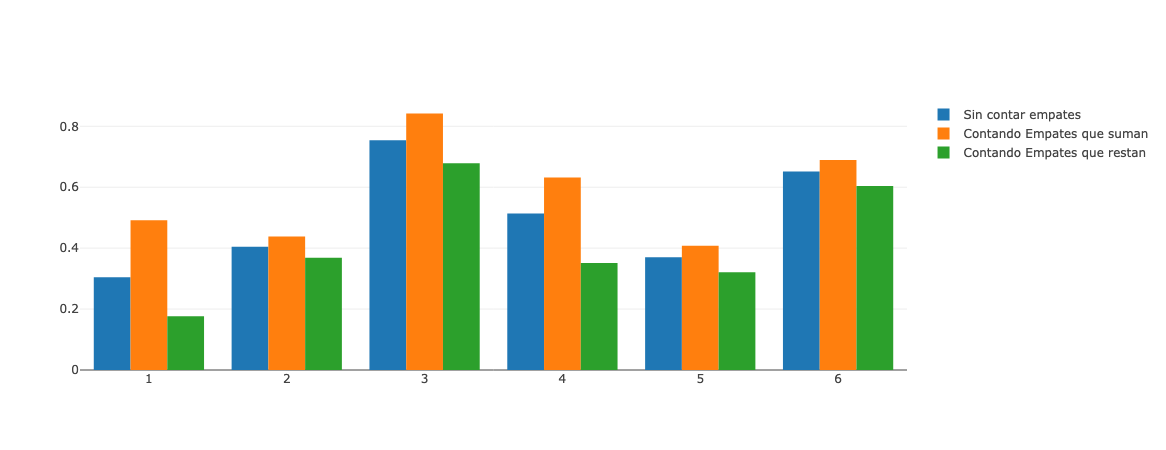

In [281]:
iplot(fig)

#